| Morphogen gradient parameter      | Scaling   |
|-----------------------------------|-----------|
| $ w $ for SHH                     | static    | 
| $ x_0 $ for SHH                   | static    | 
| $ \lambda $ for SHH               | static    |
| $ w $ for FGF8                    | static    | 
| $ x_0 $ for FGF8                  | static    | 
| $ \lambda $ for FGF8              | static    | 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

In [3]:
# function for numerical scheme in custom package 
from euler_scheme_1d_with_growth.analytical_solutions import steady_solution, nrect
from euler_scheme_1d_with_growth.two_morph import Lfinal
import matplotlib.patches as patches

In [4]:
from euler_scheme_1d_with_growth.matplotlib_defaults import *

In [5]:
# assume to be 1
D0      = 1
beta0   = 1
alpha0  = 1
lam0    = math.sqrt(D0/beta0) 

L_to_plot = [1.8 * lam0, 3.6 * lam0]

# supported by experiments
x00    = 0.4*lam0
w0     = 0.4*lam0

# proportionality coefficient for scaling

b_lam   = lam0 / L_to_plot[0]
b_xw    = x00 / L_to_plot[0]
b_alpha = alpha0 / min(L_to_plot)

sc_lam_keys = ['no', 'D', 'mixed', 'beta']
#sc_lam_keys = ['no', 'D', 'beta']
#sc_s_keys   = ['', 'x', 'a', 'w', 'ax', 'xw', 'aw', 'axw']
sc_s_keys   = ['', 'x',  'w', 'xw']

color_scheme = {
    "no":    mcolors.to_rgb("black"),
    "D":     mcolors.to_rgb("cyan"),
    "mixed": mcolors.to_rgb("orange"),
    "beta":  mcolors.to_rgb("magenta")
}

def scaling_lam(b_lam, D0, beta0, alpha0, L):
    return {
        "no": {
            "lambda": math.sqrt(D0 / beta0),
            "beta":   beta0,
            "D":      D0
        },
        "D": {
            "lambda": b_lam * L,
            "beta":   beta0,
            "D":      beta0 * (b_lam * L)**2
        },
        "mixed": {
            "lambda": b_lam * L,
            "beta":   (beta0 * math.sqrt(D0 / beta0)) / (b_lam * L),
            "D":      (D0 * (b_lam * L)) / math.sqrt(D0 / beta0)
        },
        "beta": {
            "lambda": b_lam * L,
            "beta":   D0 / (b_lam * L)**2,
            "D":      D0
        }
    }

# Add elements function
def add_elements(x, y):
    return x + y if x == 0 else x

def scaling_source(b_xw, b_alpha, L, alpha0, x0, w0):
    sources = {}
    for i in range(2**2):  # 2^2 = 4 combinations
        binary_digits = [int(d) for d in f"{i:02b}"]  # Convert to 3-digit binary
        keys = "".join([char for char, digit in zip("xw", binary_digits) if digit])

        values = {
            "x0": add_elements(binary_digits[0] * (b_xw * L),    x00   ),
            "w":  add_elements(binary_digits[1] * (b_xw * L),    w0    )
        }

        sources[keys] = values
        
    return sources

In [6]:
threshold = 0.15

# Fit power function

In [7]:
from scipy.optimize import curve_fit

def fit_power_function(x, y, tol=1e-8):
    # Define the power-law model
    def power_func(x, C, power):
        return C * x**power

    # Check if y is nearly constant
    if np.std(y) / np.abs(np.mean(y)) < tol:
        C = np.mean(y)
        power = 0.0
        r_squared = 1.0
    else:
        # Normal fit
        popt, _ = curve_fit(power_func, x, y, p0=[1, 1])
        C, power = popt

    # Compute R² manually
    y_pred = C * x**power
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    return C, power, r_squared

# Plot with fit

In [8]:
def plot_Lfinal(ax, row, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution, start_col=0):
    """Plot center middle values for each scaling key."""
    for sc_lam_key in sc_lam_keys:
        Lf = []
        for L0 in Lx:
            sc_s   = scaling_source(b_xw, b_alpha, L0, alpha0, x00, w0)[sc_s_key]
            sc_lam = scaling_lam(b_lam, D0, beta0, alpha0, L0)[sc_lam_key]

            Lf.append( Lfinal(threshold, sc_s['x0'], sc_lam['lambda'], alpha0, sc_s['w'], sc_lam['beta'], sc_lam['D']) )
        
        Lf = np.array( Lf )
        Lx_to_plot = Lx[ ~np.isnan(Lf) ]
        Lf_to_plot = Lf[ ~np.isnan(Lf) ]
        
        ax[row, start_col+1].plot(Lx_to_plot, Lf_to_plot, color=np.array(color_scheme[sc_lam_key]))
        #ax[row, start_col+1].fill_between( np.linspace(0, 20, 100), 0, np.linspace(0, 20, 100), color='Lightgray') 

        # power fit
        C, power, r_squared = fit_power_function(Lx_to_plot, Lf_to_plot)
        text = f'C = {round(C)}, pow = {round(power, 2)}, R2 = {round(r_squared, 2)}'
        ax[row, start_col+1].plot(np.linspace(0, 8, 100), C * np.linspace(0, 8, 100)**power, label = text, color=np.array(color_scheme[sc_lam_key]), linestyle='--')
        ax[row, start_col+1].set_xlim(0, 6*L_to_plot[0])
        ax[row, start_col+1].set_ylim(0, 6*L_to_plot[0])
        ax[row, start_col+1].set_xticks([0, 2*L_to_plot[0], 4*L_to_plot[0], 6*L_to_plot[0]])  # Set the tick positions
        ax[row, start_col+1].set_yticks([0, 2*L_to_plot[0], 4*L_to_plot[0], 6*L_to_plot[0]])  # Set the tick positions
        ax[row, start_col+1].legend()

        ax[row, 0].set_ylabel(sc_s_key)  

        if row == 0:
            ax[row, start_col+1].set_title('Lfinal')

        # derivative
        # Plot the original line
        Lf_derivative = np.gradient(Lx_to_plot, Lf_to_plot)  # Computes d(Lf)/d(Lx)
        
        # Plot the derivative
        ax[row, start_col+2].plot(Lx_to_plot, Lf_derivative, color=np.array(color_scheme[sc_lam_key]))
        ax[row, start_col+2].set_ylim(0, 8)
        #ax[row, start_col+2].set_yticks([])
        
        if row == 0:
            ax[row, start_col+2].set_title('derLfinal')

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: divide by zero encountered in divide
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\numpy\lib\function_base.py:1259: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\numpy\lib\function_base.py:1266: RuntimeWarning: divide by zero encountered in scalar divide
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


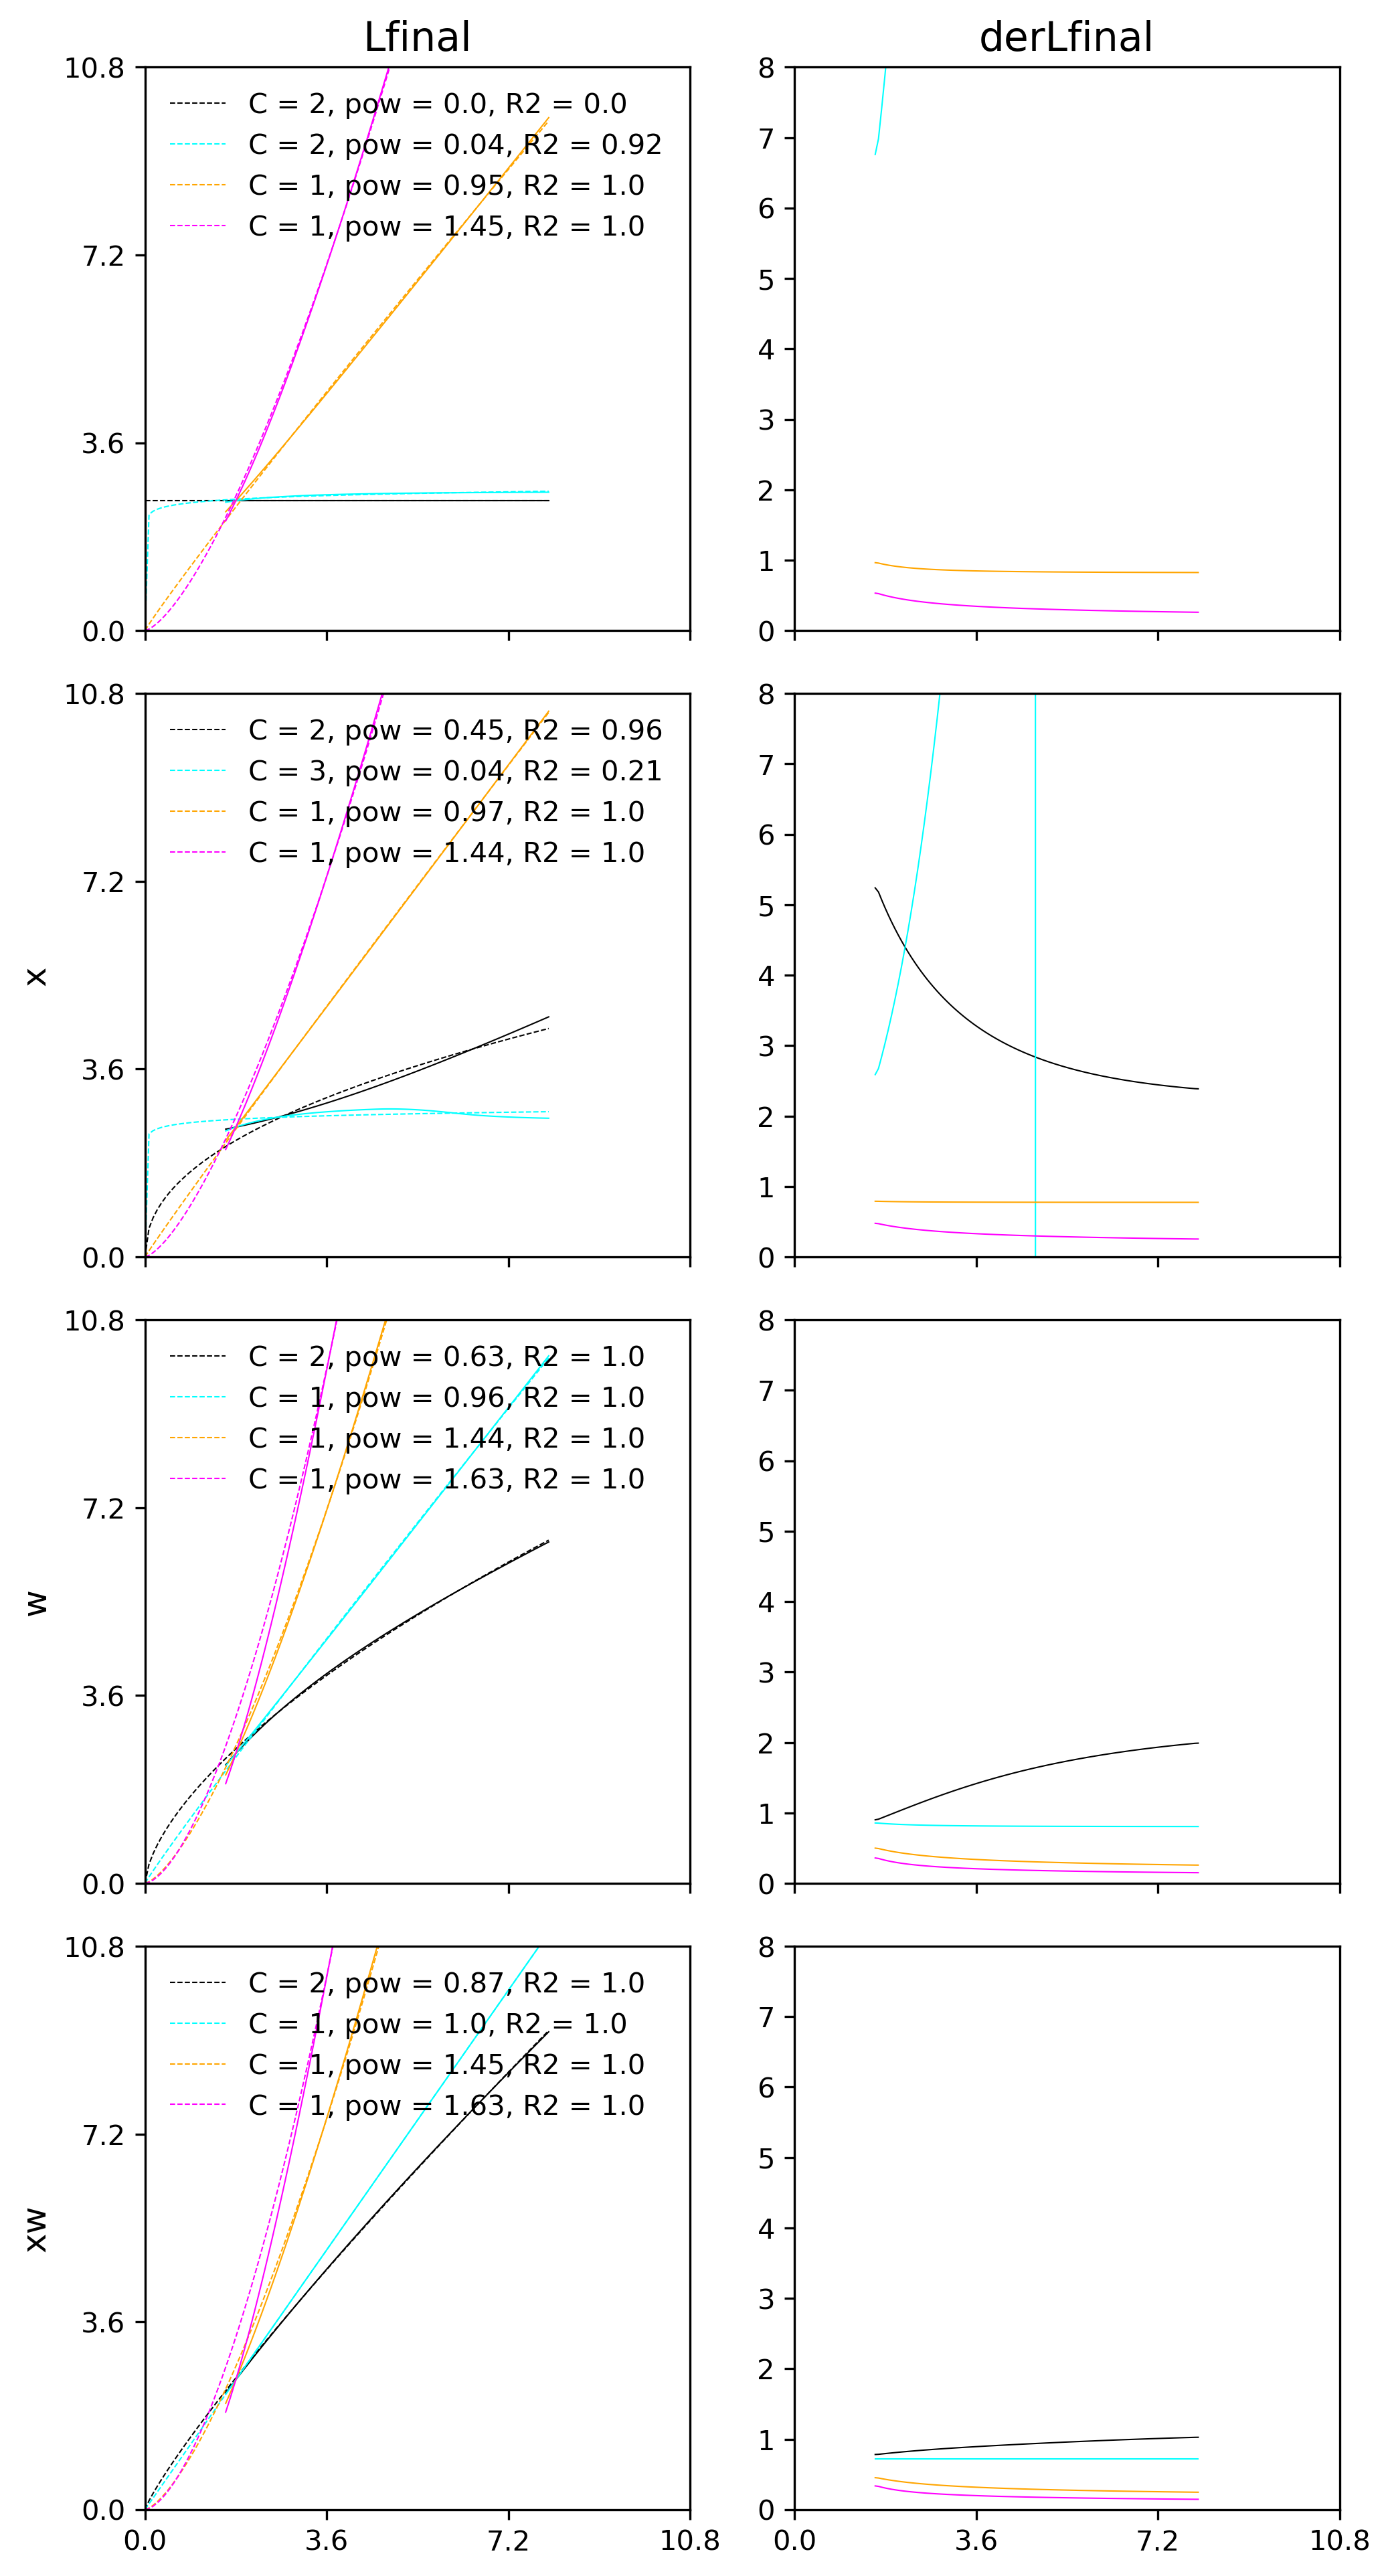

In [9]:
nrows, ncols = 4, 2

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], (3/2)*default_figsize["large"][1]), sharex=True, sharey=False)

Lx = np.linspace( 2*(x00 + w0), 8, 100 )

for i, sc_s_key in enumerate(sc_s_keys):
    #plot_cmiddle(ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)
    plot_Lfinal( ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution, start_col=-1)

plt.tight_layout()
#plt.savefig( 'fig/static_scaling_two.pdf' )
plt.show()

# Scan scaling parm

In [10]:
b_lam_to_test = np.linspace( 0.1, 0.91, 21 )
b_xw_to_test  = np.linspace( 0.01, 0.51, 21 )

In [11]:
import pandas as pd
from tqdm import tqdm

# Storage for results
results = []

# x range for fitting
Lx = np.linspace(2 * (x00 + w0), 8, 100)

for b_lam in tqdm( b_lam_to_test ):
    for b_xw in b_xw_to_test:
        for sc_s_key in sc_s_keys:
            for sc_lam_key in sc_lam_keys:
                Lf = []
                for L0 in Lx:
                    sc_s = scaling_source(b_xw, b_alpha, L0, alpha0, x00, w0)[sc_s_key]
                    sc_lam = scaling_lam(b_lam, D0, beta0, alpha0, L0)[sc_lam_key]

                    Lf.append(Lfinal(threshold, sc_s['x0'], sc_lam['lambda'], alpha0, sc_s['w'], sc_lam['beta'], sc_lam['D']))
                
                # Fit power function
                Lf = np.array( Lf )
                if len( Lf[ ~np.isnan(Lf) ] ) != 0:
                    Lx_to_fit = Lx[ ~np.isnan(Lf) ]
                    Lf_to_fit = Lf[ ~np.isnan(Lf) ]
                    C, power, r_squared = fit_power_function(Lx_to_fit, Lf_to_fit)
    
                    # Save the result
                    results.append({
                        'b_lam': b_lam,
                        'b_xw': b_xw,
                        'sc_s_key': sc_s_key,
                        'sc_lam_key': sc_lam_key,
                        'C': C,
                        'power': power,
                        'r_squared': r_squared
                    })

# Convert to DataFrame
df = pd.DataFrame(results)

# Save to Excel
df.to_excel('power_fit_results.xlsx', index=False)

print("Saved results to 'power_fit_results.xlsx'.")

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]C:\Users\naly008c\AppData\Local\Temp\ipykernel_5660\208491206.py:22: RuntimeWarning: invalid value encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
 24%|███████████████████▊                                                               | 5/21 [02:40<08:35, 32.20s/it]


KeyboardInterrupt: 

In [ ]:
df

In [ ]:
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# Filter high-quality fits only
df_filtered = df[df['r_squared'] > 0.95].copy()
df_filtered['power'] = df_filtered['power'].clip(lower=1e-3)

# Unique keys
sc_s_keys_unique = ['', 'x', 'w', 'xw']#np.sort(df_filtered['sc_s_key'].unique())
sc_lam_keys_unique = ['no', 'D', 'mixed', 'beta']#np.sort(df_filtered['sc_lam_key'].unique())

# 2D grids
b_xw_values = np.sort(df_filtered['b_xw'].unique())
b_lam_values = np.sort(df_filtered['b_lam'].unique())

# Custom diverging colormap centered at 1 (white)
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # blue → white → red
custom_cmap = LinearSegmentedColormap.from_list('blue_white_red', colors, N=256)

# Diverging norm centered at 1
norm = TwoSlopeNorm(vmin=1e-2, vcenter=1, vmax=3)

# Subplot grid
nrows = len(sc_s_keys_unique)
ncols = len(sc_lam_keys_unique)
fig, axs = plt.subplots(nrows, ncols,
                        figsize=(4 * ncols, 4 * nrows),
                        sharex=True, sharey=True)

# Fix axs shape for edge cases
if nrows == 1 and ncols == 1:
    axs = np.array([[axs]])
elif nrows == 1:
    axs = np.array([axs])
elif ncols == 1:
    axs = np.array([[ax] for ax in axs])

# Plot each subplot
for i, sc_s_key in enumerate(sc_s_keys_unique):
    for j, sc_lam_key in enumerate(sc_lam_keys_unique):
        ax = axs[i, j]

        # Filter data
        sub_df = df_filtered[(df_filtered['sc_s_key'] == sc_s_key) & (df_filtered['sc_lam_key'] == sc_lam_key)]

        # Fill grid
        power_grid = np.full((len(b_lam_values), len(b_xw_values)), np.nan)
        for _, row in sub_df.iterrows():
            ii = np.where(b_lam_values == row['b_lam'])[0][0]
            jj = np.where(b_xw_values == row['b_xw'])[0][0]
            power_grid[ii, jj] = row['power']

        # Title based on power range from filtered data
        valid_vals = sub_df['power'].values
        if valid_vals.size > 0:
            vmin_local = valid_vals.min()
            vmax_local = valid_vals.max()
            range_str = f"{vmin_local:.2f}–{vmax_local:.2f}"
        else:
            range_str = "No data"

        # Plot
        im = ax.imshow(power_grid, origin='lower',
                       extent=[b_xw_values.min(), b_xw_values.max(), b_lam_values.min(), b_lam_values.max()],
                       aspect='equal', cmap=custom_cmap, norm=norm)

        # Axis labels
        if i == nrows - 1:
            ax.set_xlabel(f'sc_lam_key={sc_lam_key}\nb_xw')
        if j == 0:
            ax.set_ylabel(f'sc_s_key={sc_s_key}\nb_lam')

        ax.set_title(f'{range_str}', fontsize=10)

# Shared colorbar
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', shrink=0.8)
cbar.set_label('Fitted Power (white = 1)')

plt.tight_layout()
plt.show()

In [ ]:
df_selected = df[ df['power'] > 0.6 ]
df_selected = df_selected[ df_selected['power'] < 0.7 ]

In [ ]:
def select_rows_close_to_value(df, column, target_value, tolerance):
    mask = np.abs(df[column] - target_value) <= tolerance
    return df[mask]

In [ ]:
df_selected = df_selected[ df_selected['sc_s_key'] == 'x' ]
df_selected = df_selected[ df_selected['sc_lam_key'] == 'no' ]
df_selected = df_selected[ df_selected['r_squared'] > 0.988 ]

In [ ]:
df_selected

In [ ]:
# 1,2
#b_lam = 0.18#10
#b_xw  = 0.48#5	

# 3
b_lam = 0.14#10
b_xw  = 0.34#5	

# 4
# b_lam = 0.14#10
# b_xw  = 0.41#5	

In [ ]:
nrows, ncols = 4, 2

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], (3/2)*default_figsize["large"][1]), sharex=True, sharey=False)

Lx = np.linspace( 2*(x00 + w0), 8, 100 )

for i, sc_s_key in enumerate(sc_s_keys):
    #plot_cmiddle(ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)
    plot_Lfinal( ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution, start_col=-1)

plt.tight_layout()
plt.savefig( 'fig/allometric_static_scaling_two.pdf' )
plt.show()

In [ ]:
10.8 / 1.8